In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
!pip install torchsummary

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Ghost Batch Normalization

In [ ]:
class BN(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GBN(BN):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


## Model

In [ ]:
dropout_value = 0.07
num_splits = 2

class Net(nn.Module):
    def __init__(self, norm_type = 'BN'):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10) if norm_type == 'BN' else GBN(num_features=10, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 26

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0),
            nn.BatchNorm2d(20) if norm_type == 'BN' else GBN(num_features=20, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 24

        # transition block 
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10) if norm_type == 'BN' else GBN(num_features=10, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12
        # end

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10) if norm_type == 'BN' else GBN(num_features=10, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 10

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding = 0),
            nn.BatchNorm2d(16) if norm_type == 'BN' else GBN(num_features=16, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8

        #
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1), 
        #     nn.BatchNorm2d(20) if norm_type == 'BN' else GBN(num_features=16, num_splits=num_splits),
        #     nn.Dropout(dropout_value),
        #     nn.ReLU()
        # )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 0), 
            nn.BatchNorm2d(16) if norm_type == 'BN' else GBN(num_features=16, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 1),
            nn.BatchNorm2d(16) if norm_type == 'BN' else GBN(num_features=16, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6( padding = 1)

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size = 6)
        ) # output_size = 1

        # final FC layer (read fully convolutional, not fully connected)
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=1),
            nn.BatchNorm2d(20) if norm_type == 'BN' else GBN(num_features=20, num_splits=num_splits),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1)
        )

        self.dropout = nn.Dropout(dropout_value)
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv_1_1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            # x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = self.gap(x)
            x = self.conv8(x)
            x = self.conv9(x)

            x = x.view(-1, 10)
            return F.log_softmax(x, dim = -1)


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,820
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             210
        MaxPool2d-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

## Train Test

In [ ]:
from tqdm import tqdm

# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

train_losses = {1:[], 2:[], 3:[], 4:[], 5:[]}
test_losses = {1:[], 2:[], 3:[], 4:[], 5:[]}
train_acc = {1:[], 2:[], 3:[], 4:[], 5:[]}
test_acc = {1:[], 2:[], 3:[], 4:[], 5:[]}

index_metric = 1 # indexing for accessing the ith metric

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

def train(model, device, train_loader, optimizer, epoch, reg = None, lambda_l1 = 1e-4):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad() # setting the gradients to zero after every backprop step

    y_pred = model(data) # predicting the values

    l1_reg = sum([torch.sum(abs(param)) for param in model.parameters()])
    l1_loss = l1_reg * lambda_l1

    nll = F.nll_loss(y_pred, target)

    if (reg == 'None'):
        loss = nll

    elif (reg == 'l1'):
        loss = nll + l1_loss

    elif (reg == 'l2'):
        # optimizer.weight_decay = weight_decay
        loss = nll
    
    elif (reg == 'l1_l2'):
        # optimizer.weight_decay = weight_decay
        loss = nll + l1_loss

    elif (reg == 'GBN'):
        loss = nll

    else: # GBN + L1 + L2
        # optimizer.weight_decay = 1e-4
        loss = nll + l1_loss


    train_losses.get(index_metric).append(loss)
    loss.backward() # backpropagation
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    accuracy = 100. * correct / processed

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100. * correct / processed:0.2f}')
    train_acc.get(index_metric).append(100. * correct / processed)



In [ ]:
def test(model, device, test_loader):
    '''
    Test function to validate the model
    '''
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # since we do not want to compute gradients on the test data, we use torch.no_grad()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target)
            pred = output.argmax(dim=1, keepdim = True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.get(index_metric).append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.get(index_metric).append(100. * correct / len(test_loader.dataset))

## Model run

In [ ]:
from torch.optim.lr_scheduler import StepLR
EPOCHS = 20

def run(epochs, norm_type = 'BN', lambda_l1 = 0, lambda_l2 = 0):
    '''
    Trains and tests the model.
    '''
    model = Net(norm_type=norm_type).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=lambda_l2)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    for epoch in range(1, epochs + 1):
        # if(epoch == 1):
        #     print(' ' + norm_type)
        print('Epoch:',  epoch)  
        train(model, device, train_loader, optimizer, epoch, lambda_l1)
        scheduler.step()
        test(model, device, test_loader)
    # print(optimizer.param_groups[0]['weight_decay'])

## Misclassified images

In [ ]:
# misclassified = {1:[], 2:[], 3:[], 4:[], 5:[]}
# misclassified_pred = {1:[], 2:[], 3:[], 4:[], 5:[]}
# misclassified_target = {1:[], 2:[], 3:[], 4:[], 5:[]}
# misclassification_index = 1

def get_misclassified():
    '''
    To get the misclassified images and their predicted and original values during the testing.
    '''
    misclassified = []
    misclassified_pred = []
    misclassified_target = []

    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
            # move them to the respective device
            data, target = data.to(device), target.to(device)
            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

# Metrics

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

# train_metric = (train_acc, train_losses)
# test_metric = (test_acc, test_losses)


def plot_metrics(train_metric, test_metric, exp_name):
    '''
    To plot the train and test accuracies and losses.
    '''

    (train_acc, train_losses) = train_metric
    (test_acc, test_losses) = test_metric

    fig, axs = plt.subplots(2,2,figsize=(14,10))
    fig.suptitle(exp_name)
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")
    plt.show()


def plot_misclassification(misclassified):
    '''
    To plot the misclassified images during testing of the model.
    '''

    # print('Total Misclassifications : {}'.format(len(misclassified)))
    num_images = 25
    fig = plt.figure(figsize=(12, 14))
    fig.suptitle('Misclassifications')
    for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
        image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu() # converting the image back into numpy array for output
        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.set_title('target {}\n pred {}'.format(target.item(), pred.item()), fontsize=16)
        ax.imshow(image.squeeze())
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# for cases in combos.values():
#     print(combos
#     break
#     run(*cases)

# Run model

In [ ]:
combos = {'L1' : (EPOCHS, 'BN', 5e-4, 0),
          'L2' : (EPOCHS, 'BN', 0, 5e-3),
          'L1_L2' : (EPOCHS, 'BN', 5e-4, 5e-3),
          'L1_L2_GBN' : (EPOCHS, 'GBN', 5e-4, 5e-3),
          'GBN' : (EPOCHS, 'GBN', 0, 0)
          }


In [ ]:
for key, value in combos.items():
    print('\n\n' + '* ' * 20 + key + ' *' * 20)
    run(*value)

    index_metric += 1

    # # get accuracy curves
    # plot_metrics(train_metric, test_metric)
    
    # # get misclassified images
    # misclassified = get_misclassified()
    # plot_misclassification(misclassified)

  0%|          | 0/938 [00:00<?, ?it/s]



* * * * * * * * * * * * * * * * * * * * L1 * * * * * * * * * * * * * * * * * * * *
Epoch: 1


Loss=0.2429039478302002 Batch_id=937 Accuracy=91.11: 100%|██████████| 938/938 [00:36<00:00, 26.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 9748/10000 (97.48%)

Epoch: 2


Loss=0.11945582926273346 Batch_id=937 Accuracy=96.82: 100%|██████████| 938/938 [00:35<00:00, 26.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9867/10000 (98.67%)

Epoch: 3


Loss=0.09204599261283875 Batch_id=937 Accuracy=97.32: 100%|██████████| 938/938 [00:36<00:00, 25.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9895/10000 (98.95%)

Epoch: 4


Loss=0.10287916660308838 Batch_id=937 Accuracy=97.73: 100%|██████████| 938/938 [00:36<00:00, 25.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9877/10000 (98.77%)

Epoch: 5


Loss=0.1712377816438675 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9902/10000 (99.02%)

Epoch: 6


Loss=0.2651364505290985 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:35<00:00, 26.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9922/10000 (99.22%)

Epoch: 7


Loss=0.08683432638645172 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:35<00:00, 26.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.39%)

Epoch: 8


Loss=0.11774547398090363 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [00:35<00:00, 26.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9935/10000 (99.35%)

Epoch: 9


Loss=0.10485886037349701 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:35<00:00, 26.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9939/10000 (99.39%)

Epoch: 10


Loss=0.154694065451622 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:35<00:00, 26.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.42%)

Epoch: 11


Loss=0.11753962934017181 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:35<00:00, 26.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9946/10000 (99.46%)

Epoch: 12


Loss=0.07822615653276443 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:35<00:00, 26.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9940/10000 (99.40%)

Epoch: 13


Loss=0.09352271258831024 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:35<00:00, 26.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9948/10000 (99.48%)

Epoch: 14


Loss=0.11616785824298859 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:35<00:00, 26.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.45%)

Epoch: 15


Loss=0.07942736893892288 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:35<00:00, 26.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9947/10000 (99.47%)

Epoch: 16


Loss=0.09556234627962112 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:35<00:00, 26.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9944/10000 (99.44%)

Epoch: 17


Loss=0.25328826904296875 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:35<00:00, 26.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.45%)

Epoch: 18


Loss=0.1006540060043335 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:35<00:00, 26.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.42%)

Epoch: 19


Loss=0.16659361124038696 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:35<00:00, 26.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9944/10000 (99.44%)

Epoch: 20


Loss=0.10200029611587524 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:35<00:00, 26.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9945/10000 (99.45%)



* * * * * * * * * * * * * * * * * * * * L2 * * * * * * * * * * * * * * * * * * * *
Epoch: 1


Loss=0.2747848331928253 Batch_id=937 Accuracy=91.24: 100%|██████████| 938/938 [00:36<00:00, 25.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 9658/10000 (96.58%)

Epoch: 2


Loss=0.11124059557914734 Batch_id=937 Accuracy=96.65: 100%|██████████| 938/938 [00:36<00:00, 26.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9847/10000 (98.47%)

Epoch: 3


Loss=0.17770780622959137 Batch_id=937 Accuracy=97.04: 100%|██████████| 938/938 [00:36<00:00, 26.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9830/10000 (98.30%)

Epoch: 4


Loss=0.1403571367263794 Batch_id=937 Accuracy=97.19: 100%|██████████| 938/938 [00:36<00:00, 25.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9856/10000 (98.56%)

Epoch: 5


Loss=0.1005469337105751 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:36<00:00, 25.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9804/10000 (98.04%)

Epoch: 6


Loss=0.10615783929824829 Batch_id=937 Accuracy=97.21: 100%|██████████| 938/938 [00:36<00:00, 25.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9828/10000 (98.28%)

Epoch: 7


Loss=0.07751139998435974 Batch_id=937 Accuracy=98.37: 100%|██████████| 938/938 [00:36<00:00, 25.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9924/10000 (99.24%)

Epoch: 8


Loss=0.13325069844722748 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:36<00:00, 25.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9934/10000 (99.34%)

Epoch: 9


Loss=0.08036983013153076 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:36<00:00, 25.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9930/10000 (99.30%)

Epoch: 10


Loss=0.19954811036586761 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:38<00:00, 24.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9933/10000 (99.33%)

Epoch: 11


Loss=0.13892093300819397 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:38<00:00, 24.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9939/10000 (99.39%)

Epoch: 12


Loss=0.06337955594062805 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:37<00:00, 24.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9944/10000 (99.44%)

Epoch: 13


Loss=0.140485018491745 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:38<00:00, 24.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9943/10000 (99.43%)

Epoch: 14


Loss=0.1622636616230011 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:37<00:00, 25.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9942/10000 (99.42%)

Epoch: 15


Loss=0.07487650215625763 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:36<00:00, 25.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9940/10000 (99.40%)

Epoch: 16


Loss=0.11402761936187744 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:36<00:00, 25.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9944/10000 (99.44%)

Epoch: 17


Loss=0.08250453323125839 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:36<00:00, 25.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9943/10000 (99.43%)

Epoch: 18


Loss=0.09084933996200562 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:36<00:00, 25.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9943/10000 (99.43%)

Epoch: 19


Loss=0.05630476027727127 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:36<00:00, 25.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9947/10000 (99.47%)

Epoch: 20


Loss=0.1155889630317688 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:36<00:00, 25.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9946/10000 (99.46%)



* * * * * * * * * * * * * * * * * * * * L1_L2 * * * * * * * * * * * * * * * * * * * *
Epoch: 1


Loss=0.2712269425392151 Batch_id=937 Accuracy=91.22: 100%|██████████| 938/938 [00:36<00:00, 25.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 9782/10000 (97.82%)

Epoch: 2


Loss=0.13143035769462585 Batch_id=937 Accuracy=96.92: 100%|██████████| 938/938 [00:36<00:00, 25.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 9775/10000 (97.75%)

Epoch: 3


Loss=0.1592535674571991 Batch_id=937 Accuracy=97.06: 100%|██████████| 938/938 [00:36<00:00, 25.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9802/10000 (98.02%)

Epoch: 4


Loss=0.12888947129249573 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:36<00:00, 25.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 9837/10000 (98.37%)

Epoch: 5


Loss=0.17637749016284943 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:36<00:00, 25.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9817/10000 (98.17%)

Epoch: 6


Loss=0.12471295893192291 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:36<00:00, 25.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9826/10000 (98.26%)

Epoch: 7


Loss=0.29184725880622864 Batch_id=937 Accuracy=98.34: 100%|██████████| 938/938 [00:36<00:00, 25.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9922/10000 (99.22%)

Epoch: 8


Loss=0.19306620955467224 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:36<00:00, 25.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9934/10000 (99.34%)

Epoch: 9


Loss=0.2846832275390625 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:36<00:00, 25.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9935/10000 (99.35%)

Epoch: 10


Loss=0.14330537617206573 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:36<00:00, 25.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9940/10000 (99.40%)

Epoch: 11


Loss=0.057640038430690765 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:36<00:00, 25.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9922/10000 (99.22%)

Epoch: 12


Loss=0.1282234638929367 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:36<00:00, 25.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9940/10000 (99.40%)

Epoch: 13


Loss=0.10390180349349976 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:36<00:00, 25.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9943/10000 (99.43%)

Epoch: 14


Loss=0.05703026056289673 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:36<00:00, 25.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9942/10000 (99.42%)

Epoch: 15


Loss=0.07101888954639435 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:36<00:00, 25.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9943/10000 (99.43%)

Epoch: 16


Loss=0.0639440268278122 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:36<00:00, 25.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9939/10000 (99.39%)

Epoch: 17


Loss=0.05684414878487587 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:36<00:00, 25.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9944/10000 (99.44%)

Epoch: 18


Loss=0.05391424894332886 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [00:36<00:00, 25.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9943/10000 (99.43%)

Epoch: 19


Loss=0.0677124485373497 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:36<00:00, 25.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9942/10000 (99.42%)

Epoch: 20


Loss=0.08982963860034943 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:36<00:00, 25.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9942/10000 (99.42%)



* * * * * * * * * * * * * * * * * * * * L1_L2_GBN * * * * * * * * * * * * * * * * * * * *
Epoch: 1


Loss=0.164761021733284 Batch_id=937 Accuracy=89.65: 100%|██████████| 938/938 [00:37<00:00, 25.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 9788/10000 (97.88%)

Epoch: 2


Loss=0.40983060002326965 Batch_id=937 Accuracy=96.13: 100%|██████████| 938/938 [00:36<00:00, 25.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 9856/10000 (98.56%)

Epoch: 3


Loss=0.1816062033176422 Batch_id=937 Accuracy=96.63: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9827/10000 (98.27%)

Epoch: 4


Loss=0.0982661247253418 Batch_id=937 Accuracy=96.75: 100%|██████████| 938/938 [00:37<00:00, 25.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9822/10000 (98.22%)

Epoch: 5


Loss=0.3505118489265442 Batch_id=937 Accuracy=96.93: 100%|██████████| 938/938 [00:37<00:00, 25.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9813/10000 (98.13%)

Epoch: 6


Loss=0.1047825813293457 Batch_id=937 Accuracy=96.95: 100%|██████████| 938/938 [00:37<00:00, 25.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 9797/10000 (97.97%)

Epoch: 7


Loss=0.2755046784877777 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:37<00:00, 25.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9926/10000 (99.26%)

Epoch: 8


Loss=0.08500558137893677 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:37<00:00, 25.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9943/10000 (99.43%)

Epoch: 9


Loss=0.08578316867351532 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:36<00:00, 25.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9944/10000 (99.44%)

Epoch: 10


Loss=0.15203256905078888 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:37<00:00, 25.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9921/10000 (99.21%)

Epoch: 11


Loss=0.11074225604534149 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:37<00:00, 25.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9940/10000 (99.40%)

Epoch: 12


Loss=0.07287540286779404 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:37<00:00, 25.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9936/10000 (99.36%)

Epoch: 13


Loss=0.06594587862491608 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:37<00:00, 25.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9943/10000 (99.43%)

Epoch: 14


Loss=0.16290920972824097 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:37<00:00, 25.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9946/10000 (99.46%)

Epoch: 15


Loss=0.1019117459654808 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:37<00:00, 25.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9952/10000 (99.52%)

Epoch: 16


Loss=0.0770600289106369 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:37<00:00, 24.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9946/10000 (99.46%)

Epoch: 17


Loss=0.2508348226547241 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:37<00:00, 25.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9949/10000 (99.49%)

Epoch: 18


Loss=0.08920496702194214 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:37<00:00, 25.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9948/10000 (99.48%)

Epoch: 19


Loss=0.07916053384542465 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:37<00:00, 25.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9949/10000 (99.49%)

Epoch: 20


Loss=0.13804765045642853 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:37<00:00, 24.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Accuracy: 9947/10000 (99.47%)



* * * * * * * * * * * * * * * * * * * * GBN * * * * * * * * * * * * * * * * * * * *
Epoch: 1


Loss=0.21638259291648865 Batch_id=937 Accuracy=90.82: 100%|██████████| 938/938 [00:37<00:00, 25.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 9772/10000 (97.72%)

Epoch: 2


Loss=0.10076360404491425 Batch_id=937 Accuracy=96.47: 100%|██████████| 938/938 [00:37<00:00, 25.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 9861/10000 (98.61%)

Epoch: 3


Loss=0.19430269300937653 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [00:37<00:00, 25.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9901/10000 (99.01%)

Epoch: 4


Loss=0.12059943377971649 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:37<00:00, 25.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9907/10000 (99.07%)

Epoch: 5


Loss=0.2182905077934265 Batch_id=937 Accuracy=97.46: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, Accuracy: 9898/10000 (98.98%)

Epoch: 6


Loss=0.2382204234600067 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:37<00:00, 25.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9883/10000 (98.83%)

Epoch: 7


Loss=0.0988226979970932 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:36<00:00, 25.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9926/10000 (99.26%)

Epoch: 8


Loss=0.38880205154418945 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:37<00:00, 25.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9933/10000 (99.33%)

Epoch: 9


Loss=0.2741330862045288 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:37<00:00, 25.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9933/10000 (99.33%)

Epoch: 10


Loss=0.18198435008525848 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [00:37<00:00, 25.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9932/10000 (99.32%)

Epoch: 11


Loss=0.15547716617584229 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:37<00:00, 25.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9932/10000 (99.32%)

Epoch: 12


Loss=0.2509475648403168 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:37<00:00, 25.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9934/10000 (99.34%)

Epoch: 13


Loss=0.26626527309417725 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:36<00:00, 25.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.41%)

Epoch: 14


Loss=0.16171211004257202 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:37<00:00, 25.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9940/10000 (99.40%)

Epoch: 15


Loss=0.1616007387638092 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:37<00:00, 25.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9941/10000 (99.41%)

Epoch: 16


Loss=0.09385234117507935 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:37<00:00, 25.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9938/10000 (99.38%)

Epoch: 17


Loss=0.16575169563293457 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:37<00:00, 25.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.42%)

Epoch: 18


Loss=0.1453593373298645 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:37<00:00, 25.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.42%)

Epoch: 19


Loss=0.13348601758480072 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:36<00:00, 25.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0003, Accuracy: 9942/10000 (99.42%)

Epoch: 20


Loss=0.23908214271068573 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:37<00:00, 25.15it/s]



Test set: Average loss: 0.0003, Accuracy: 9936/10000 (99.36%)



# Plots

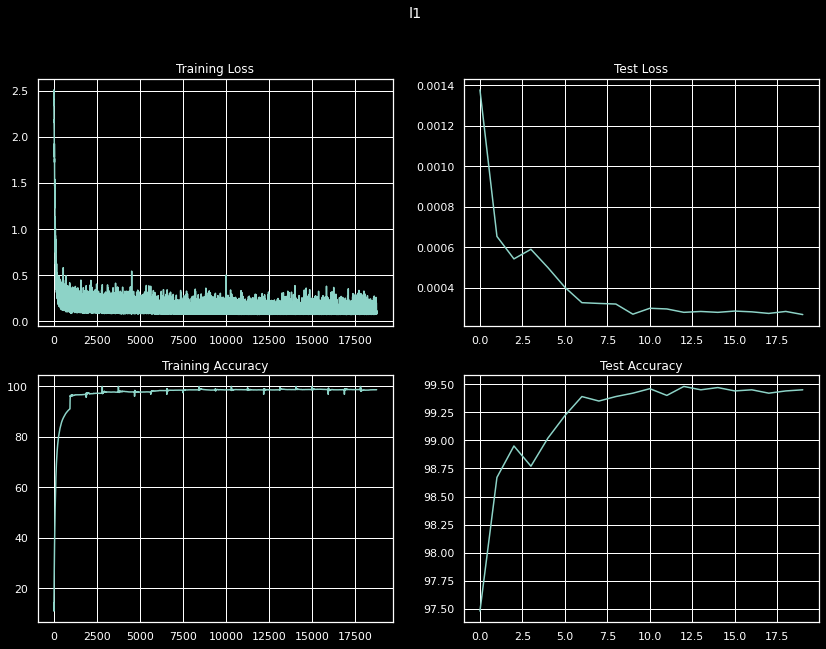

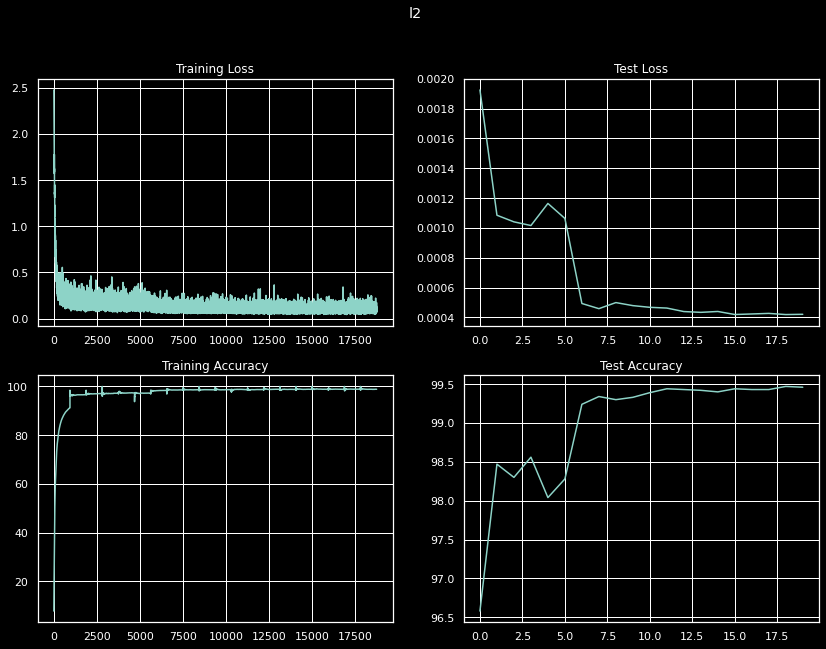

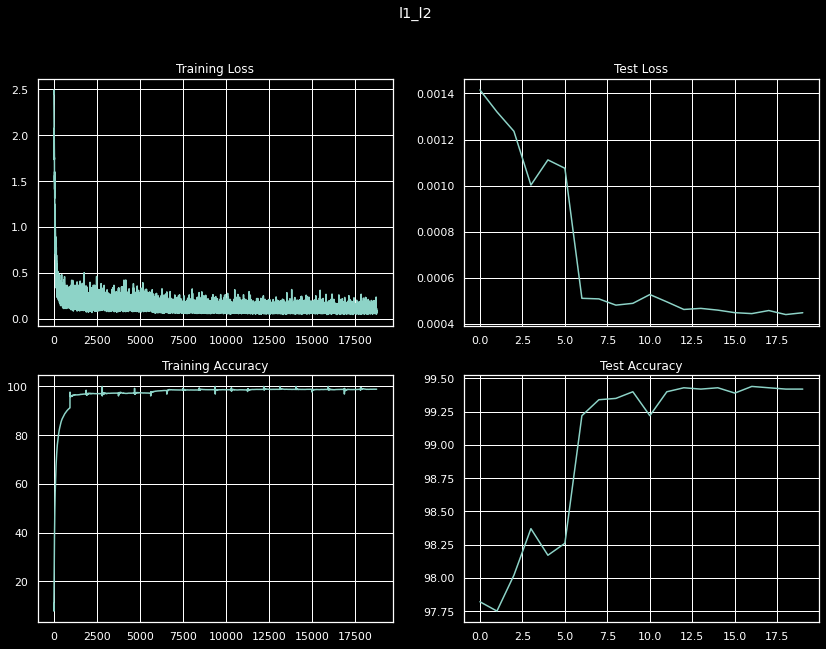

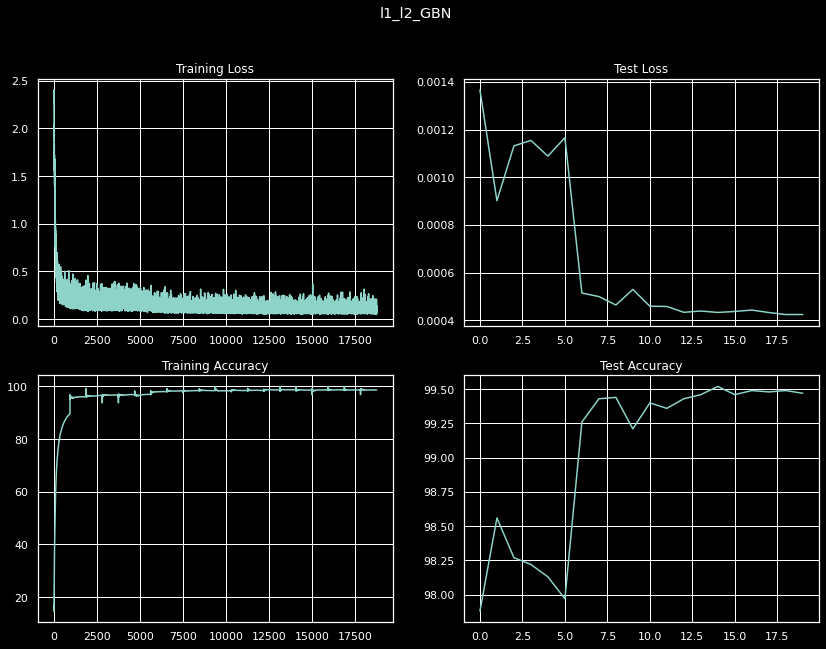

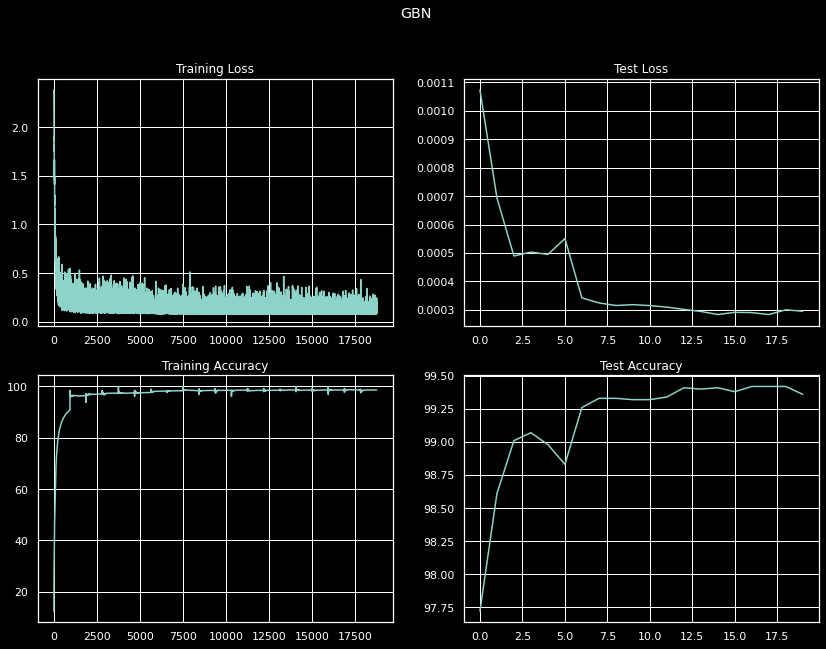

In [ ]:
labels = ['l1', 'l2', 'l1_l2', 'l1_l2_GBN', 'GBN']

for idx in range(1, index_metric):
    train_metric = (train_acc[idx], train_losses[idx])
    test_metric = (test_acc[idx], test_losses[idx])

    plot_metrics(train_metric, test_metric, labels[idx-1])

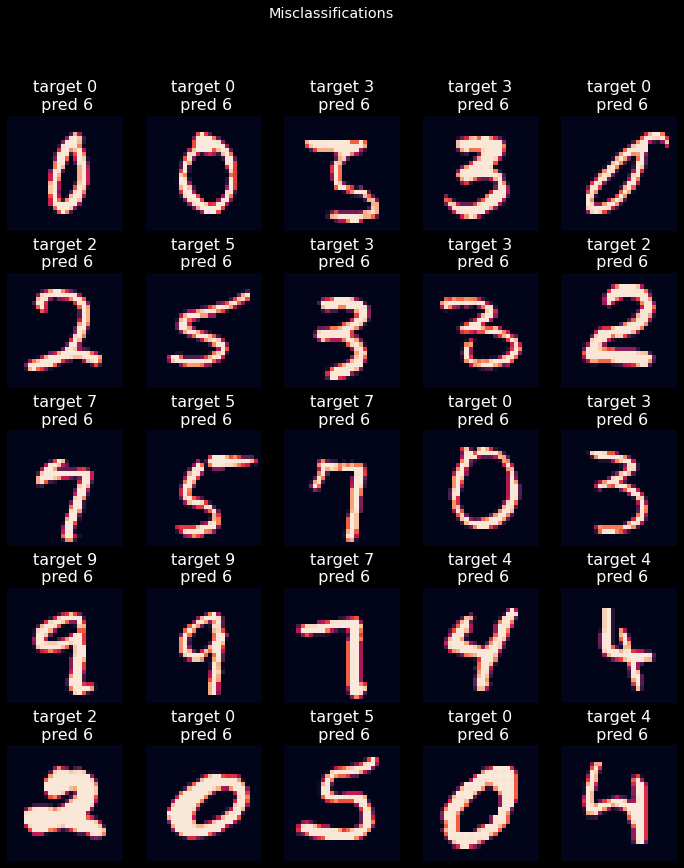

In [ ]:
# get misclassified images for 'with GBN only' experiment
misclassified = get_misclassified()
plot_misclassification(misclassified)

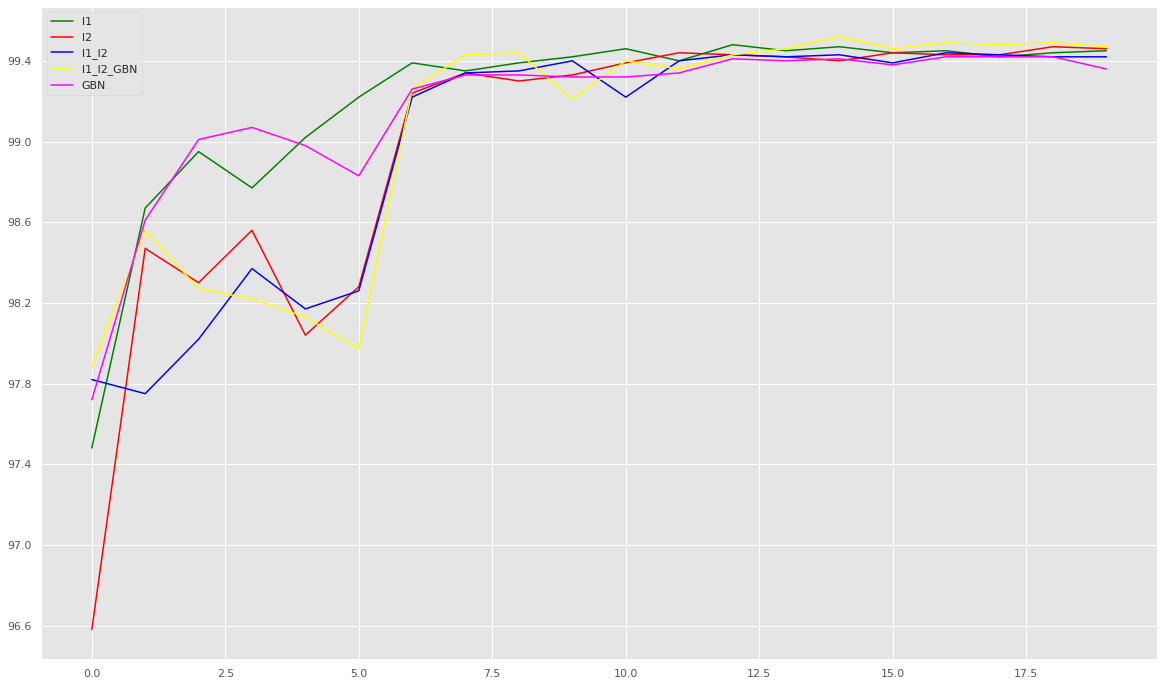

In [ ]:
labels = ['l1', 'l2', 'l1_l2', 'l1_l2_GBN', 'GBN']
import seaborn as sns; sns.set()
import numpy as np

plt.style.use('ggplot')
plt.figure(figsize=(20,12))
plt.yticks(np.arange(95, 101, 0.4))


plt.plot(test_acc[1],color='Green', label = 'l1');
plt.plot(test_acc[2],color='Red', label = 'l2');
plt.plot(test_acc[3],color='Blue', label = 'l1_l2');
plt.plot(test_acc[4],color='Yellow', label = 'l1_l2_GBN');
plt.plot(test_acc[5],color='Magenta', label = 'GBN');

plt.legend(loc = 'best')
# plt.ylim([0, 100])
plt.show()

# for idx in range(1, index_metric):
#     plt.plot(train_acc[idx], label = labels[idx - 1])
#     # plt.set_title("Training Accuracy")

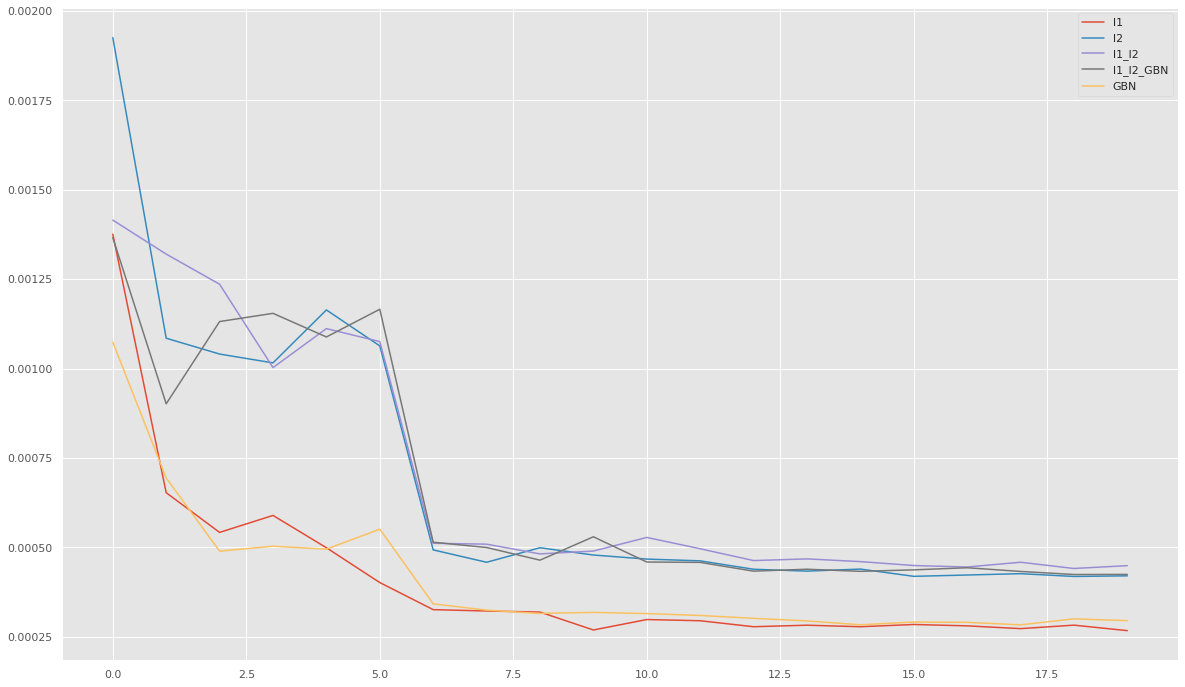

In [ ]:
labels = ['l1', 'l2', 'l1_l2', 'l1_l2_GBN', 'GBN']
import seaborn as sns; sns.set()

plt.style.use('ggplot')
plt.figure(figsize=(20,12))

for idx in range(1, index_metric):
    plt.plot(test_losses[idx], label = labels[idx - 1])
    # plt.set_title("Training Accuracy")

plt.legend(loc = 'best')
plt.show()